In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA

from tqdm import tqdm

import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('ggplot')

# Read and prepare Data first

In [3]:
SIG = pd.read_csv('data/signal.csv', sep=';')
BKG = pd.read_csv('data/background.csv', sep=';')

In [4]:
def remove_constant_columns(df):
    data = df.loc[:, (df != df.ix[0]).any()]
    return data

In [5]:
def combine_data(sig, bkg):
    ind = sig.columns.isin(bkg.columns)
    column_ind = sig.columns[ind]
    data = sig[column_ind].append(bkg[column_ind], ignore_index=True)
    labels = np.append(np.ones(sig.shape[0]), np.zeros(bkg.shape[0]))
    return data, labels

In [6]:
SIG = remove_constant_columns(SIG)
BKG = remove_constant_columns(BKG)

In [7]:
DATA, LABELS = combine_data(SIG, BKG)
DATA = DATA.dropna(axis=1)
LABELS = pd.Series(LABELS.astype('int'))

Drop some very distinguishing features, it seems like everything containing `MC` is heavily correlated with the labels

In [8]:
DATA.filter(regex='MC|Weight|EventHeader|ID|HitStat').columns

Index(['CorsikaWeightMap.Atmosphere', 'CorsikaWeightMap.Multiplicity',
       'CorsikaWeightMap.TimeScale', 'HitStatisticsValues.cog_z_sigma',
       'HitStatisticsValues.min_pulse_time',
       'HitStatisticsValues.max_pulse_time', 'HitStatisticsValues.q_max_doms',
       'HitStatisticsValues.z_min', 'HitStatisticsValues.z_max',
       'HitStatisticsValues.z_mean', 'HitStatisticsValues.z_sigma',
       'HitStatisticsValues.z_travel', 'HitStatisticsValues.cog_x',
       'HitStatisticsValues.cog_y', 'HitStatisticsValues.cog_z',
       'I3EventHeader.Run', 'I3EventHeader.Event', 'I3EventHeader.SubEvent',
       'I3EventHeader.time_start_utc_daq', 'I3EventHeader.time_start_mjd_ns',
       'I3EventHeader.time_end_utc_daq', 'I3EventHeader.time_end_mjd_ns',
       'MCECenter.value', 'MCMostEnergeticInIce.x', 'MCMostEnergeticInIce.y',
       'MCMostEnergeticInIce.z', 'MCMostEnergeticInIce.time',
       'MCMostEnergeticInIce.zenith', 'MCMostEnergeticInIce.azimuth',
       'MCMostEnergeticInIce

In [9]:
DATA.drop(DATA.filter(regex='MC|Weight|EventHeader|ID').columns, axis=1, inplace=True);

In [10]:
# store complete dataset and randomize entries for MRMR
full_df = pd.concat([LABELS, DATA], axis=1)
filename = './data/full_dataset.csv'
idxs = np.arange(len(full_df))
np.random.shuffle(idxs)
full_df.iloc[idxs].to_csv(filename, index=False)

In [11]:
# see http://penglab.janelia.org/proj/mRMR/#c++ for the implementation
!cat data/mrmr_output.txt

You have specified parameters: threshold=mu+/-1.00*sigma #fea=50 selection method=MID #maxVar=10000 #maxSample=40000

Target classification variable (#1 column in the input data) has name=0 	entropy score=1.000

*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 35 	 MPEFitParaboloid.z 	 0.229
2 	 29 	 MPEFitHighNoise.z 	 0.227
3 	 18 	 LineFit_TT.z 	 0.227
4 	 98 	 SplineMPEMuEXDifferential.z 	 0.226
5 	 115 	 SplineMPETruncatedEnergy_SPICEMie_AllDOMS_Muon.z 	 0.226
6 	 65 	 SplineMPE.z 	 0.226
7 	 107 	 SplineMPETruncatedEnergy_SPICEMie_AllBINS_Muon.z 	 0.226
8 	 50 	 MuEXAngular4.z 	 0.226
9 	 15 	 HitStatisticsValues.cog_z 	 0.221
10 	 10 	 HitStatisticsValues.z_mean 	 0.218
11 	 25 	 LineFit_TTParams.lf_vel_z 	 0.201
12 	 57 	 SPEFit2Bayesian.z 	 0.195
13 	 95 	 SplineMPEFitParams.rlogl 	 0.187
14 	 8 	 HitStatisticsValues.z_min 	 0.186
15 	 9 	 HitStatisticsValues.z_max 	 0.160
16 	 74 	 SplineMPEDirectHitsA.n_dir_doms 	 0.135
17 	 73 	 SplineMPEDirectHitsA.n_dir_strings 	 0.

In [12]:
for i, c in enumerate(DATA.columns):
    print(i, c)

0 HitMultiplicityValues.n_hit_strings
1 HitMultiplicityValues.n_hit_doms
2 HitMultiplicityValues.n_hit_doms_one_pulse
3 HitStatisticsValues.cog_z_sigma
4 HitStatisticsValues.min_pulse_time
5 HitStatisticsValues.max_pulse_time
6 HitStatisticsValues.q_max_doms
7 HitStatisticsValues.z_min
8 HitStatisticsValues.z_max
9 HitStatisticsValues.z_mean
10 HitStatisticsValues.z_sigma
11 HitStatisticsValues.z_travel
12 HitStatisticsValues.cog_x
13 HitStatisticsValues.cog_y
14 HitStatisticsValues.cog_z
15 LineFit_TT.x
16 LineFit_TT.y
17 LineFit_TT.z
18 LineFit_TT.time
19 LineFit_TT.zenith
20 LineFit_TT.azimuth
21 LineFit_TTParams.lf_vel
22 LineFit_TTParams.lf_vel_x
23 LineFit_TTParams.lf_vel_y
24 LineFit_TTParams.lf_vel_z
25 LineFit_TTParams.n_hits
26 MPEFitHighNoise.x
27 MPEFitHighNoise.y
28 MPEFitHighNoise.z
29 MPEFitHighNoise.time
30 MPEFitHighNoise.zenith
31 MPEFitHighNoise.azimuth
32 MPEFitParaboloid.x
33 MPEFitParaboloid.y
34 MPEFitParaboloid.z
35 MPEFitParaboloid.time
36 MPEFitParaboloid.zeni

100%|██████████| 125/125 [00:21<00:00,  7.86it/s]


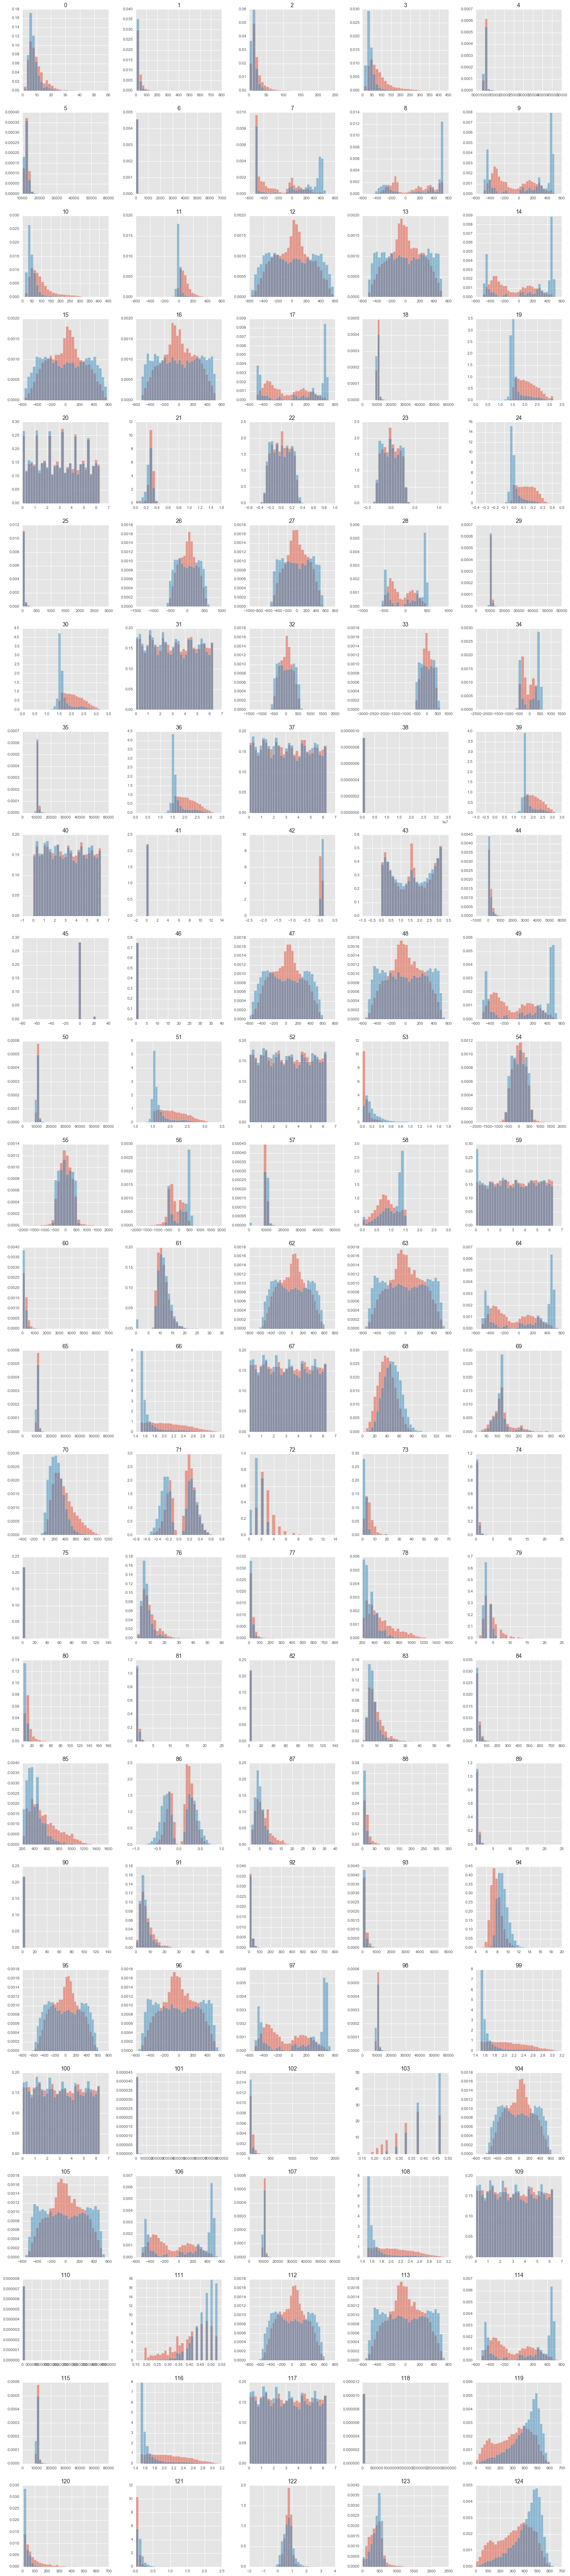

In [13]:
# Plot features, we have 157 of them this will probably take a while
plt.figure(figsize=(20, 90))
for i, feature in tqdm(enumerate(DATA.columns), total=len(DATA.columns)):
    plt.subplot(np.ceil(len(DATA.columns) / 5), 5, i+1)
    _, bins = np.histogram(DATA[feature], 30)
    plt.hist(DATA[LABELS==1][feature], bins=bins, alpha=0.5, normed=True)
    plt.hist(DATA[LABELS==0][feature], bins=bins, alpha=0.5, normed=True)
    plt.title(i)
plt.tight_layout()
plt.show()

In [14]:
gb = GradientBoostingClassifier()

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(DATA, LABELS, test_size=0.3)
gb.fit(train_data, train_labels)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [16]:
proba = gb.predict_proba(test_data)[:,1]
score = roc_auc_score(test_labels, proba)
score

0.99460023705435907

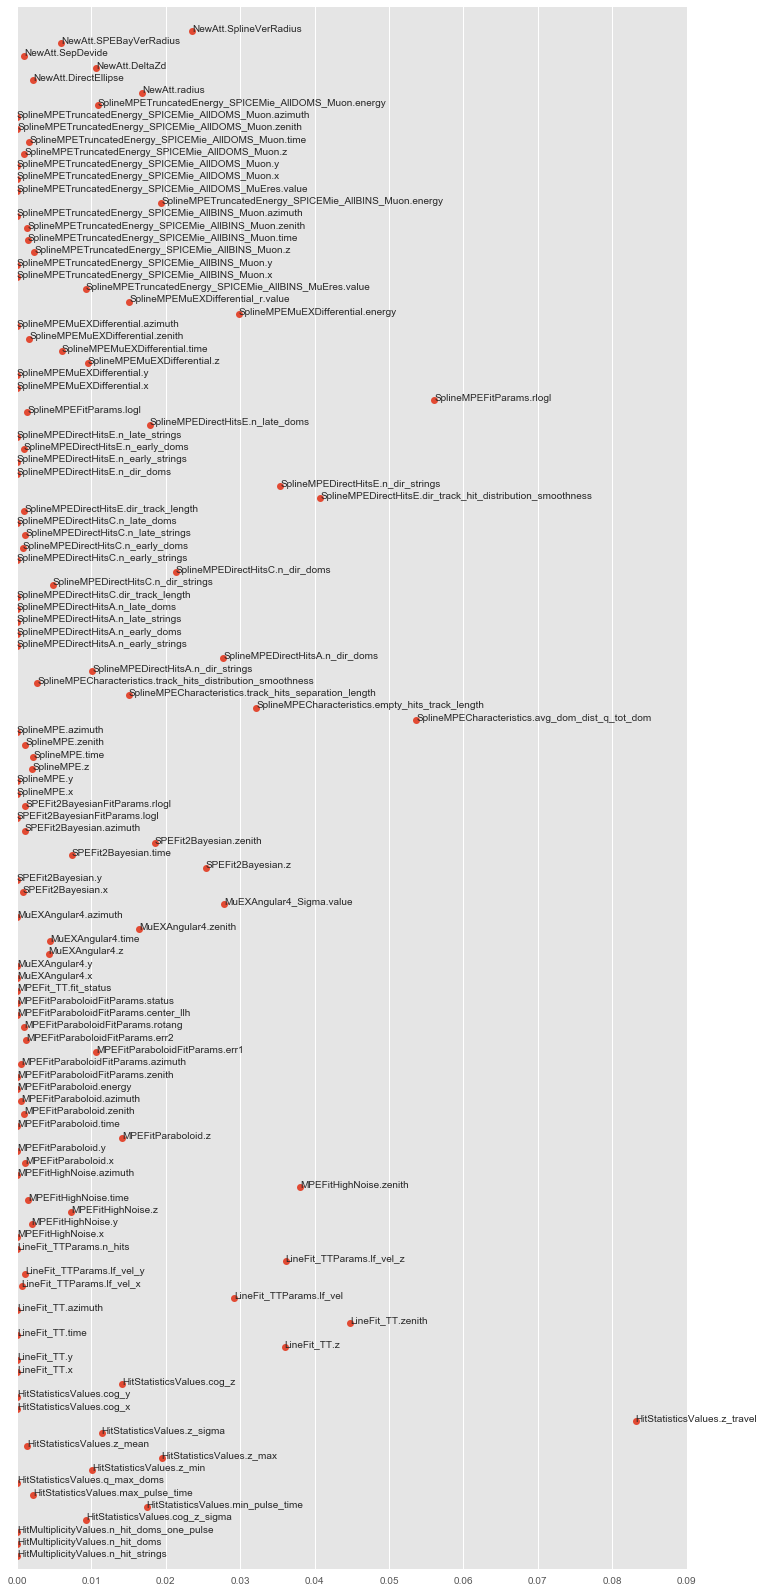

In [19]:
plt.figure(figsize=(12,28))
fis = gb.feature_importances_
plt.plot(fis, range(len(DATA.columns)), 'o')
for i, f in enumerate(DATA.columns):
    plt.annotate(f, (fis[i], i))
plt.yticks([])
plt.ylim(-1, len(DATA.columns) + 1)
plt.show()